# Simulation (plus some gold mining)

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt

from simulation.units import *
from simulation.population_sim import SubhaloSimulator

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Prior and settings

In [18]:
n_train = 25000
n_test = 5000
n_prior_samples = 1000

mass_base_unit = 1.e9 * M_s

alpha_mean = 500. # calculate 2e8/M_s * mass_base_unit * (mass_base_unit / M_s)**-1.9
alpha_std = 100.

beta_mean = -2.5
beta_std = 0.3

alpha_true = 400.
beta_true = -1.9

## Generate train data

In [19]:
alpha_train = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_train)
beta_train = np.random.normal(loc=beta_mean, scale=beta_std, size=n_train)
theta_train = np.vstack((alpha_train, beta_train)).T

assert np.min(alpha_train) > 0.
assert np.max(beta_train) < -1.

In [20]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=10.,
)

In [21]:
y0 = np.zeros(n_train)
x0, t_xz0, log_r_xz0, log_r_xz_uncertainties0, latents0 = sim.rvs_score_ratio_to_evidence(
    alpha_train,
    beta_train,
    alpha_mean,
    alpha_std,
    beta_mean,
    beta_std,
    n_train,
    n_prior_samples
)

13:51 simulation.populatio INFO    Simulating image 250 / 5000
13:53 simulation.populatio INFO    Simulating image 500 / 5000
13:54 simulation.populatio INFO    Simulating image 750 / 5000
13:56 simulation.populatio INFO    Simulating image 1000 / 5000
13:58 simulation.populatio INFO    Simulating image 1250 / 5000
14:00 simulation.populatio INFO    Simulating image 1500 / 5000
14:01 simulation.populatio INFO    Simulating image 1750 / 5000
14:03 simulation.populatio INFO    Simulating image 2000 / 5000
14:05 simulation.populatio INFO    Simulating image 2250 / 5000
14:07 simulation.populatio INFO    Simulating image 2500 / 5000
14:08 simulation.populatio INFO    Simulating image 2750 / 5000
14:10 simulation.populatio INFO    Simulating image 3000 / 5000
14:12 simulation.populatio INFO    Simulating image 3250 / 5000
14:14 simulation.populatio INFO    Simulating image 3500 / 5000
14:16 simulation.populatio INFO    Simulating image 3750 / 5000
14:18 simulation.populatio INFO    Simulati

In [22]:
y1 = np.ones(n_train)
x1, t_xz1, log_r_xz1, log_r_xz_uncertainties1, latents1 = sim.rvs_score_ratio_to_evidence_inverse(
    alpha_train,
    beta_train,
    alpha_mean,
    alpha_std,
    beta_mean,
    beta_std,
    n_train,
    n_prior_samples
)

../simulation/population_sim.py:383: RuntimeWarning: overflow encountered in double_scalars
  inverse_r_xz_uncertainty += (np.exp(log_p_xzs[i_theta + 1] - log_p_xzs[0]) - inverse_r_xz) ** 2.0
14:26 simulation.populatio INFO    Simulating image 250 / 5000
14:27 simulation.populatio INFO    Simulating image 500 / 5000
14:28 simulation.populatio INFO    Simulating image 750 / 5000
14:30 simulation.populatio INFO    Simulating image 1000 / 5000
14:31 simulation.populatio INFO    Simulating image 1250 / 5000
14:32 simulation.populatio INFO    Simulating image 1500 / 5000
14:34 simulation.populatio INFO    Simulating image 1750 / 5000
14:35 simulation.populatio INFO    Simulating image 2000 / 5000
14:36 simulation.populatio INFO    Simulating image 2250 / 5000
14:38 simulation.populatio INFO    Simulating image 2500 / 5000
14:39 simulation.populatio INFO    Simulating image 2750 / 5000
14:40 simulation.populatio INFO    Simulating image 3000 / 5000
14:41 simulation.populatio INFO    Simulati

In [23]:
x_train = np.vstack((x0, x1))
y_train = np.hstack((y0, y1))
theta_train = np.vstack((theta_train, theta_train))
log_r_xz_train = np.hstack((log_r_xz0, log_r_xz1))
t_xz_train = np.vstack((t_xz0, t_xz1))
latents = latents0 + latents1

r_xz_train = np.exp(log_r_xz_train, dtype=np.float64)
n_subs_train = np.array([v[0] for v in latents])
m_subs_train = [v[1] for v in latents]
pos_subs_train = [np.vstack((v[2], v[3])).T for v in latents]

In [24]:
if not os.path.exists("../data"):
    os.mkdir("../data")
if not os.path.exists("../data/samples"):
    os.mkdir("../data/samples")

np.save("../data/samples/theta_train.npy", theta_train)
np.save("../data/samples/x_train.npy", x_train)
np.save("../data/samples/y_train.npy", y_train)
np.save("../data/samples/t_xz_train.npy", t_xz_train)
np.save("../data/samples/r_xz_train.npy", r_xz_train)
np.save("../data/samples/log_r_xz_train.npy", log_r_xz_train)
np.save("../data/samples/n_subs_train.npy", n_subs_train)


## Generate test data

In [25]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=10.,
)

x0, _ = sim.rvs(alpha_true, beta_true, n_test)
y0 = np.zeros(n_test)

alpha1_test = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_test)
beta1_test = np.random.normal(loc=beta_mean, scale=beta_std, size=n_test)

x1, _ = sim.rvs(alpha1_test, beta1_test, n_test)
y1 = np.ones(n_test)

x_test = np.vstack((x0, x1))
y_test = np.hstack((y0, y1))
theta_test = np.array([[alpha_true, beta_true] for i in range(2*n_test)])

14:51 simulation.populatio INFO    Simulating image 25 / 500
14:51 simulation.populatio INFO    Simulating image 50 / 500
14:52 simulation.populatio INFO    Simulating image 75 / 500
14:52 simulation.populatio INFO    Simulating image 100 / 500
14:52 simulation.populatio INFO    Simulating image 125 / 500
14:52 simulation.populatio INFO    Simulating image 150 / 500
18:53 simulation.populatio INFO    Simulating image 175 / 500
18:53 simulation.populatio INFO    Simulating image 200 / 500
18:53 simulation.populatio INFO    Simulating image 225 / 500
18:54 simulation.populatio INFO    Simulating image 250 / 500
18:54 simulation.populatio INFO    Simulating image 275 / 500
18:55 simulation.populatio INFO    Simulating image 300 / 500
18:55 simulation.populatio INFO    Simulating image 325 / 500
18:55 simulation.populatio INFO    Simulating image 350 / 500
18:55 simulation.populatio INFO    Simulating image 375 / 500
18:56 simulation.populatio INFO    Simulating image 400 / 500
18:56 simul

In [26]:
if not os.path.exists("../data"):
    os.mkdir("../data")

np.save("../data/theta_test.npy", theta_test)
np.save("../data/x_test.npy", x_test)
np.save("../data/y_test.npy", y_test)

## A first look at the data

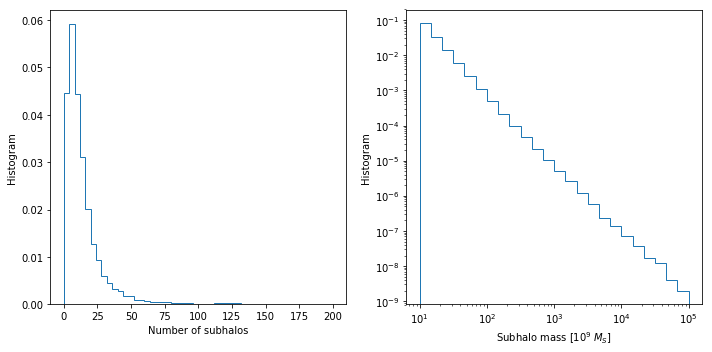

In [27]:
fig = plt.figure(figsize=(10,5))

# Number of subhalos
ax = plt.subplot(1,2,1)
plt.hist(n_subs_train, bins=50, range=(0,200), histtype='step', density=True)
plt.xlabel(r'Number of subhalos')
plt.ylabel(r'Histogram')

# Masses
ax = plt.subplot(1,2,2)
bins = 10**(np.linspace(1., 5., 25))
plt.hist(np.hstack(m_subs_train), bins=bins, histtype='step', density=True)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.xlabel(r'Subhalo mass [$10^9 \; M_S$]')
plt.ylabel(r'Histogram')

plt.tight_layout()
plt.savefig("../figures/subhalo_params.pdf")

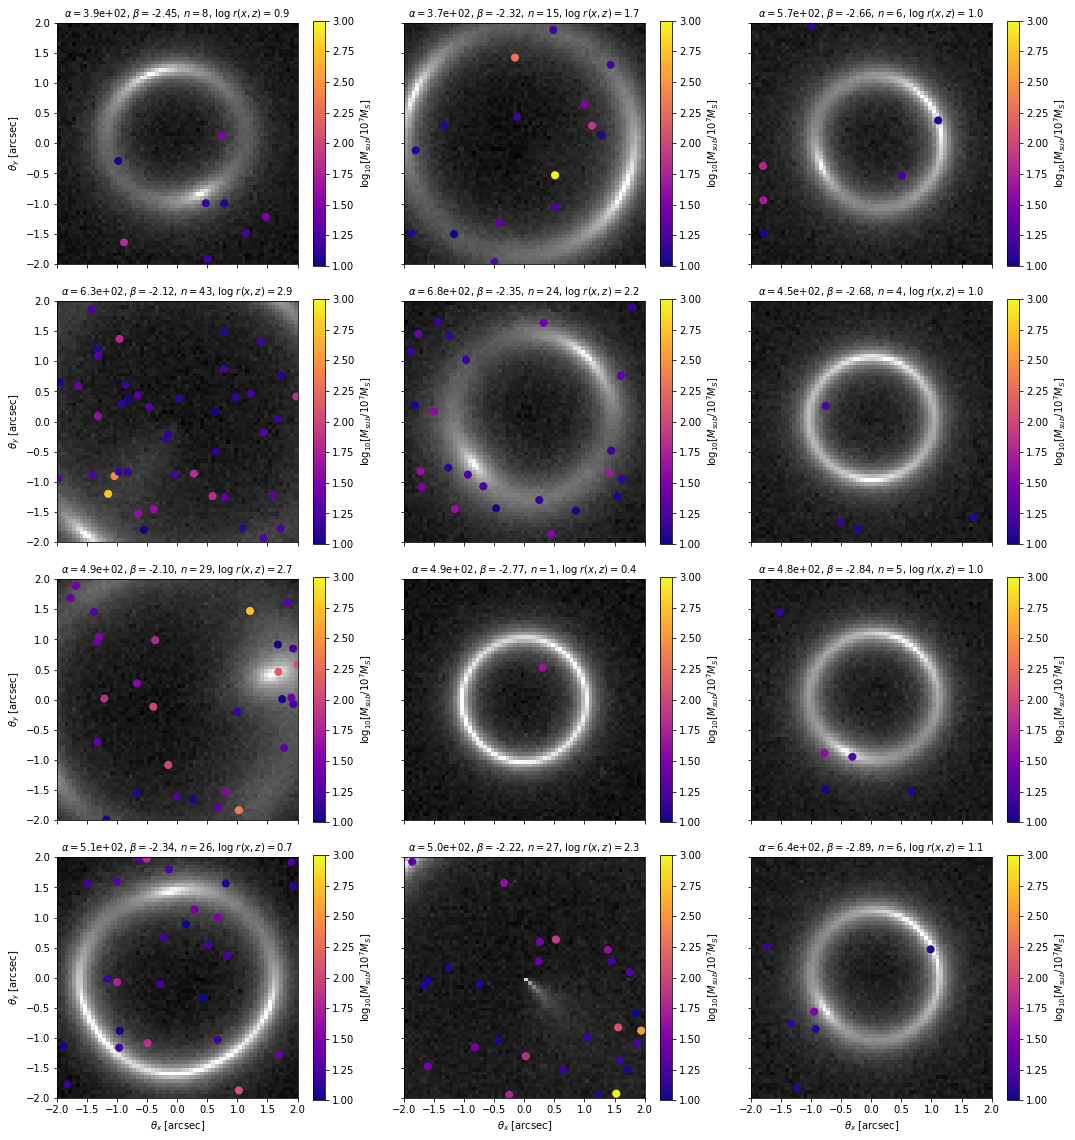

In [28]:
plt.figure(figsize=(15,16))

for i in [9,10,11,0,3,6,1,2,4,5,7,8]:
    if i == 9:
        ax_y = plt.subplot(4,3,i+1)
        ax_x = ax_y
    elif i in [10,11]:
        ax_x = plt.subplot(4,3,i+1, sharey=ax_y)
    elif i in [0,3,6]:
        ax_y = plt.subplot(4,3,i+1, sharex=ax_x)
    else:
        ax = plt.subplot(4,3,i+1, sharey=ax_y, sharex=ax_x)
        
    plt.imshow(
        np.log10(x_train[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    sc = plt.scatter(
        pos_subs_train[i][:,0],
        pos_subs_train[i][:,1],
        s=50.,
        c=np.log10(m_subs_train[i][:]),
        cmap="plasma",
        vmin=1.,
        vmax=3.,
    )
    cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    description = r"$\alpha = ${:.1e}, $\beta = ${:.2f}, $n = {}$, $\log \; r(x,z) = ${:.1f}".format(
            alpha_train[i],
            beta_train[i],
            n_subs_train[i],
            log_r_xz_train[i]
        )
    plt.title(
        description,
        fontsize=10
    )
    if i in [9,10,11]:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    if i in [0,3,6,9]:
        plt.ylabel(r"$\theta_y$ [arcsec]")
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    cbar.set_label(r'$\log_{10} [M_{sub} / 10^7 M_S]$')
    
    
plt.tight_layout()
plt.savefig("../figures/subhalos.pdf")